# Importing Packages and API Setup

In [ ]:
# Only needs to be run upon first-time use
import sys
!{sys.executable} -m pip install alpha_vantage
!{sys.executable} -m pip install quandl

In [1]:
import numpy as np
import scipy.stats as stats
import itertools as it
import pandas as pd
import cmath as c
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import datetime as dt
import quandl as q
import time
# https://github.com/RomelTorres/alpha_vantage
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators 
from alpha_vantage.sectorperformance import SectorPerformances

In [2]:
API_URL = 'https://www.alphavantage.co/query?'

api_keys = ['TMANNBF5NO707ZEI', 
            'AO48IFCXLA3BX1O9', 
            'GDJZQ31AX2TZRFA1',
            'APHZP2X3GZ7UQ7NO',
            'X9LEOT46QKZHC0O9',
            'WA71OD0SUMQLQV08',
            'AO48IFCXLA3BX1O9',
            'WH1I0K3RY7Y3958F',
            '1ZATCR2Y62I9FJF6',
            '2IWCSQNSOEXOFOOJ']

# Quandl API key
q.ApiConfig.api_key = "ntUKZwApL5qnmU9pk_rB"

# Reference API calls:
# Output formats: json dictionaries (default), DataFrame, csv.
# csv does not support ForeignExchange, SectorPerformances, TechIndicators.
# indexing_type can also be integer (default: date)
# TimeSeries(key=<api_keys[i]>, output_format='pandas', indexing_type='date'), 
# TechIndicators(key= <api_keys[i]>, output_format='pandas', indexing_type='date'), 
# SectorPerformances(key=<api_keys[i]>, output_format='pandas', indexing_type='date'), 

# Data Collection Methods

This is the primary method for retrieving data from the AlphaVantage API. Rather than worrying about all of the individual data collection methods, this method allows the user to just specify the key parameters, and the appropriate API method retrieves the data. Because the API only allows for 5 calls/minute, each block of ticker calls can be made one at a time every minute. Thus, **`collect()` is HIGHLY RECOMMENDED** as it prevents errors related to exceeding the 5 calls/minute rate.

In [3]:
# Used to get individual stock data from the AlphaVantage API.
# symbol: a single stock ticker symbol.
# start_date, end_date: string of date 'YYYY-MM-DD'.
# intra_int: intraday interval; '1min', '5min', '15min', '30min', '60min' (default '15min').
# api_index: corresponds to string API key in api_keys list.
# brute_force: prevent API KeyErrors by recursively calling the API until the call is processed.
def get_data(symbol, start_date=None, end_date=None, int_type='daily_adjusted', 
             intra_int='15min', api_index=0, brute_force=True):
    
    try:
        # Assign the AlphaVatange API call corresponding to the input api key.
        ts = TimeSeries(key = api_keys[api_index], output_format='pandas', indexing_type='date')

        # Gather the stock price data; either daily adjusted or intraday.
        if int_type is 'daily_adjusted':
            data, meta = ts.get_daily_adjusted(symbol=symbol, outputsize='full')
        else: 
            data, meta = ts.get_intraday(symbol=symbol, interval=intra_int, outputsize='full')

        # Remove numbers from column labels.
        data.rename(columns=lambda col: col[3:], inplace=True)

        # Filter the DataFrame to contain only those specified by the start and end dates.
        if start_date and end_date:
            data = data.loc[start_date:end_date]
        elif start_date:
            data = data.loc[start_date:]
        else:
            data = data.loc[:end_date]

        # Add the stock data to a DataFrame and reindex to be DateTime indices.
        df_stock = pd.DataFrame(data)
        df_stock.index = pd.to_datetime(df_stock.index)
        
        return df_stock
    
    except KeyError as ke:
        if brute_force:
            api_index = (api_index + 1)%len(api_keys)
            return get_data(symbol, start_date, end_date, int_type, intra_int, api_index)

In [4]:
# Primary method for acquring stock data. Recommended over get_data() because
# it avoids the 5 API calls/min limitation by inherently waiting 1 minute if
# more than 5 stocks are being called at once.
# tickers: list of ticker strings
# start_date, end_date: string of date 'YYYY-MM-DD'
# brute_force: see get_data().
def collect(tickers, start=None, end=None, int_type='daily_adjusted', intra_int='15min', brute_force=True):   
    
    final_port = {}
    input_set = set(tickers)
    
    for t in enumerate(tickers):
        i, sym = t
        d = get_data(sym, start, end, int_type, intra_int, api_index=i%len(api_keys), 
                     brute_force=brute_force)
        print(i%len(api_keys))
        final_port[sym] = d
        print(sym, type(d), ('%.0f'%((i + 1)/len(tickers)*100))+'%')
        input_set.remove(sym)

    return final_port

In [5]:
# Safety method to ensure no DataFrame in Portfolio is Nonetype
def verify(collected_dict):
    
    modified = collected_dict
    
    start = str(list(modified.values())[0].index[0])[:-9]
    end = str(list(modified.values())[0].index[-1])[:-9]
    none_types = []
    
    for s, d in modified.items():
        if d is None:
            print(s)
            none_types.append(s)
    print(none_types)
            
    if len(none_types) > 0:
        t1 = list(modified.values())[0].index[1]
        print(t1)
        t2 = list(modified.values())[0].index[0]
        delta_m = (t1 - t2).components.minutes
        print(delta_m)
        delta_h = (t1 - t2).components.hours
        print(delta_h)
   
        if delta_m < 1 and delta_h < 1:
            re_run = collect(none_types, start, end)
        elif delta_h == 1:
            re_run = collect(none_types, start, end, int_type='intraday', intra_int='60min')
        else:
            re_run = collect(none_types, start, end, int_type='intraday', intra_int= (str(delta_m)+'min'))
    
        for n in none_types:
            modified.pop(n)
        print('Re-runs: ', re_run.keys())
        modified.update(re_run)
        print('Fixed NoneTypes!')
        return modified

    else:
        print('No NoneTypes found!')
        return modified

In [6]:
# Used to calculate the daily percent change, log returns, and
# cumulative returns over time for each stock in the portfolio.
# portfolio_dict: obtained from the collect() method
def calculate_returns(portfolio_dict):
    
    port_rets = {}
    
    for symb, data in portfolio_dict.items():

        # Get price close data.
        daily_close = data['close']

        # Calculate percent change for each period.
        daily_pct_change = daily_close.pct_change()
        daily_pct_change.fillna(0, inplace=True)

        # Calculate log returns for each period.
        daily_log_returns = np.log(daily_close.pct_change()+1)
        daily_log_returns.fillna(0, inplace=True)

        # Cumulative daily rate of return is useful to determine the 
        # value of an investment at regular intervals.
        cum_daily_return = (1 + daily_pct_change).cumprod()
        port_rets[symb] = pd.DataFrame({'pct change': daily_pct_change, 
                                   'log returns':daily_log_returns, 
                                   'cumulative daily':cum_daily_return})
    return port_rets

# Construct the Portfolio and Timeframe

In [7]:
tickers = ['LKQ', 'ZUO', 'HRTX', 'QQQ', 'PAGS', 'COMM', 'ACM', 'IIPR']

today = dt.datetime.today()

# Enter start date (default set to 1 year ago)
start = dt.datetime(today.year - 1, today.month, today.day).strftime('%Y-%m-%d')

# Default set to today
end = today.strftime('%Y-%m-%d')

In [8]:
port = collect(tickers, start, end)

0
LKQ <class 'pandas.core.frame.DataFrame'> 12%
1
ZUO <class 'pandas.core.frame.DataFrame'> 25%
2
HRTX <class 'pandas.core.frame.DataFrame'> 38%
3
QQQ <class 'pandas.core.frame.DataFrame'> 50%
4
PAGS <class 'pandas.core.frame.DataFrame'> 62%
5
COMM <class 'pandas.core.frame.DataFrame'> 75%
6
ACM <class 'pandas.core.frame.DataFrame'> 88%
7
IIPR <class 'pandas.core.frame.DataFrame'> 100%


In [10]:
returns = calculate_returns(port)

In [14]:
port['LKQ']

,open,high,low,close,adjusted close,volume,dividend amount,split coefficient
date,,,,,,,,
2018-05-14,30.45,30.8100,30.3450,30.60,30.60,2018772.0,0.0,1.0
2018-05-15,30.39,30.5400,30.2400,30.32,30.32,1731485.0,0.0,1.0
2018-05-16,30.41,30.8100,30.2450,30.62,30.62,1878552.0,0.0,1.0
2018-05-17,30.50,30.6500,30.3800,30.53,30.53,1207393.0,0.0,1.0
2018-05-18,30.42,30.5800,30.3400,30.48,30.48,1750715.0,0.0,1.0
2018-05-21,30.67,30.8780,30.5200,30.77,30.77,1496218.0,0.0,1.0
2018-05-22,30.78,30.9900,30.1400,30.15,30.15,1316917.0,0.0,1.0
2018-05-23,30.08,30.1100,29.6500,29.77,29.77,2365097.0,0.0,1.0
2018-05-24,29.81,30.2100,29.7100,30.07,30.07,3050765.0,0.0,1.0


# Plotting

In [10]:
# ticker: stock symbol
# price_type: 'adjusted close' (default), 'close', 'open'
# Returns matplotlib objects as well
def plot_returns(port_dict, rets_dict, ticker, price_type='adjusted close'):

    # Plot price action
    price = port_dict[ticker][price_type].plot(
        figsize=(15,3), label=ticker, legend=False)
    plt.title(f'{ticker} Historical Price Action')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.show()

    # Plot daily pct change
    pct_change = rets_dict[ticker]['pct change'].plot(
        figsize=(15,3), label=ticker,legend=False)
    plt.title(f'{ticker} Daily Percent Change')
    plt.xlabel('Date')
    plt.ylabel('Daily Percent Return')
    plt.show()

    # Plot cumulative returns
    cum_daily = rets_dict[ticker]['cumulative daily'].plot(
        figsize=(15,3), label=ticker,legend=False)
    plt.title(f'{ticker} Cumulative Daily Returns')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Percent Return')
    plt.show()

    return price, pct_change, cum_daily

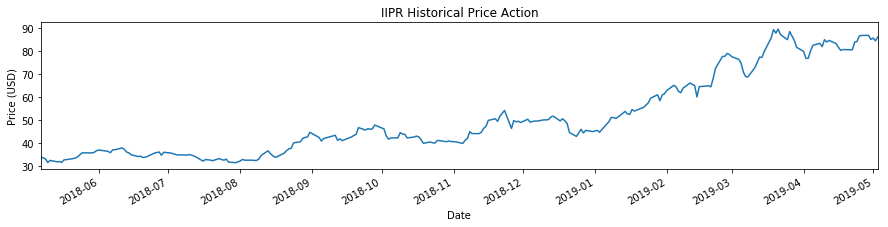

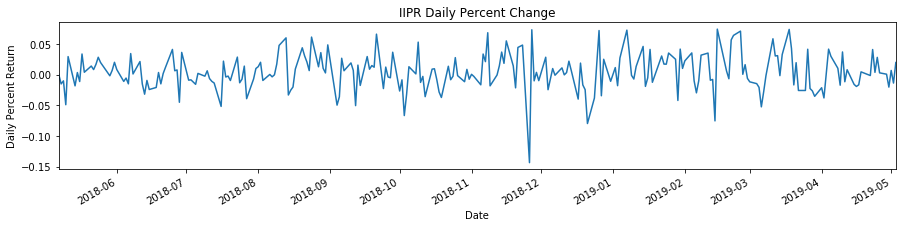

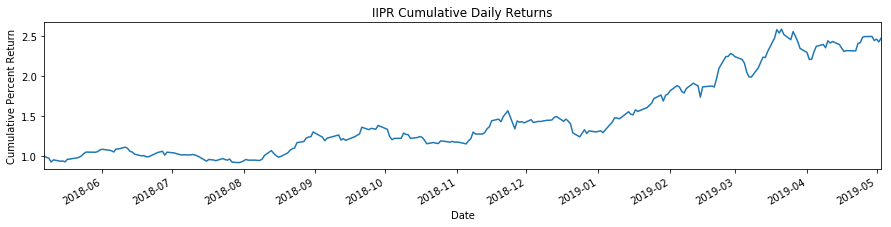

In [11]:
plot_returns(port, returns, 'IIPR');

# Statistical Measurements

In [12]:
def plot_cdf(returns_dict, ticker):
    
    r = returns_dict[ticker]['pct change']  
    ax = sns.distplot(r,
                      rug=True,
                      hist_kws=dict(cumulative=True), 
                      kde_kws=dict(cumulative=True))
    ax.set_title(ticker + ' CDF')
    ax.set_ylabel('Density')
    ax.set_xlabel('% Change of Returns')
    plt.show()
    
    moments = pd.DataFrame(columns=['Mean', 
                                    'SD', 
                                    'Skew', 
                                    'Kurtosis',
                                   'Normal (JB)'])
    
    vals = pd.Series([float('%.3f'%(r.mean())),
                         float('%.3f'%(r.std())),
                         float('%.3f'%(r.skew())),
                         float('%.3f'%(r.kurtosis())),
                         stats.jarque_bera(r)[1] > 0.05],
                        index=moments.columns).rename('')
    moments = moments.append(vals)
    
    return moments

In [13]:
# Plot the volatility (i.e. standard deviation) of an asset in the portfolio.
# show_price: if True, also plots price data of the stock.
# show_benchmark: if True, also plots volatility of S&P 500.
def plot_volatility(port_dict, returns_dict, ticker, min_periods=25, show_price=False, show_bench=False):
    
    global price, bench_vol
    price= None
    bench_vol= None
    p = port_dict
    r = returns_dict

    # Get the asset volatility and optionally the S&P volatility and price data of the asset.    
    vol = r[ticker]['pct change'].rolling(min_periods).std()*np.sqrt(min_periods)
    if show_bench:
        start = str(r[ticker].index[0])[:-9]
        end = str(r[ticker].index[-1])[:-9]
        spy_price = collect(['SPY'], start, end)
        p.update(spy_price)
        r.update(calculate_returns(spy_price))
        bench_data = p['SPY']
        bench_rets = r['SPY']
        bench_vol = bench_rets['pct change'].rolling(min_periods).std()*np.sqrt(min_periods)
    if show_price:
        price = p[ticker]['close']
    
    fig, ax1 = plt.subplots(figsize=(12,3))
    
    vol_color = 'tab:red'
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Percent')
    ax1.plot(vol, color=vol_color, label=ticker)
    ax1.legend(loc=1)
    
    if show_bench:
        bench_color='tab:orange'
        ax1.plot(bench_vol, color=bench_color, label='S&P')
        ax1.legend(loc=1)
    if show_price:
        ax2 = ax1.twinx() # second axes with same x-axis
        price_color = 'tab:blue'
        ax2.set_ylabel(f'{ticker} Price')
        ax2.plot(price, color=price_color, label=f'{ticker} price')
        ax2.tick_params(axis='y', labelcolor=price_color)
        ax2.legend(loc=2)
    vol.dropna()
    asset_mean = vol.mean()
    asset_std_dev = vol.std()
    asset_std_err = vol.sem()
    
    bench_mean = bench_vol.mean()
    bench_std_dev = bench_vol.std()
    bench_std_err = bench_vol.sem()
    
    fig.tight_layout()
    plt.title(f'{ticker} vs. S&P: Volatility ({min_periods}-Day Rolling Period)')
    plt.show()
        
    vol_stats = pd.DataFrame(index=['mean', 'std dev', 'std err'])
    vol_stats[ticker] = pd.Series((asset_mean, asset_std_dev, asset_std_err), index=vol_stats.index)
    vol_stats['S&P 500'] = pd.Series((bench_mean, bench_std_dev, bench_std_err), index=vol_stats.index)
    
    agree=False
    if asset_mean <= bench_mean and asset_mean + asset_std_err >= bench_mean:
        agree = True
    elif asset_mean >= bench_mean and asset_mean - asset_std_err <= bench_mean:
        agree=True
    
    p.pop('SPY')
    r.pop('SPY')
    print(vol_stats) 
    print(f'S&P and {ticker} agree within std error: {agree}')

0
SPY <class 'pandas.core.frame.DataFrame'> 100%


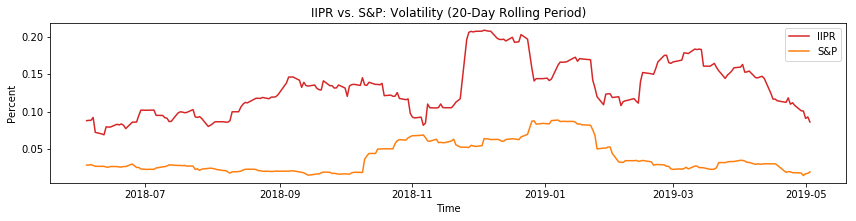

             IIPR   S&P 500
mean     0.130416  0.037977
std dev  0.035164  0.020856
std err  0.002314  0.001372
S&P and IIPR agree within std error: False


In [14]:
plot_volatility(port, returns, 'IIPR', min_periods=20, show_bench=True)

In [15]:
start = str(list(returns.values())[0].index[0])[:-9]
end = str(list(returns.values())[0].index[-1])[:-9]

In [16]:
def plot_linreg(port_dict, ticker_1, ticker_2, price_type='close', visible=True):
    
    params = stats.linregress(port_dict[ticker_1][price_type],
                    port_dict[ticker_2][price_type])
        
    if visible:
        ax = sns.regplot(x=port_dict[ticker_1][price_type], 
                y=port_dict[ticker_2][price_type])
        ax.set_xlabel(ticker_1)
        ax.set_ylabel(ticker_2)
        start = port_dict[ticker_1].index[0].strftime('%Y-%m-%d')
        end = port_dict[ticker_1].index[-1].strftime('%Y-%m-%d')
        ax.set_title(f'{ticker_1}-{ticker_2} LR ({start} - {end})')
        plt.show()
    
    vals = pd.DataFrame(columns=['R squared', 'p value', 'std err'])
    
    v = pd.Series([float('%.3f'%(params.rvalue**2)), 
                   float('%.3f'%(params.pvalue)), 
                   float('%.3f'%(params.stderr))],
                  index=vals.columns).rename('')
    vals = vals.append(v)
    return vals

In [17]:
# MAKE CORRELATION BETWEEN LOG RETURNS NOT PRICE - Done
def spearman_corr_heatmap(returns_dict, preserve_portfolio=True, plot=True):
    
    if preserve_portfolio:
        rets = {}
        rets.update(returns_dict)
    
    col = []
    
    for sym, data in rets.items():
        row = []
        
        for s, d in rets.items():
            coeff, pval = stats.spearmanr(d['log returns'], data['log returns'])
            row.append(coeff)
    
        col.append(row)

    corr_matrix = pd.DataFrame(col, columns=rets.keys())
    corr_matrix.index = rets.keys()
    
    if plot:
        mask = np.zeros_like(corr_matrix)
        mask[np.triu_indices_from(mask)]=True
        ax = sns.heatmap(corr_matrix, 
                         annot=True,
                         mask=mask,
                         cmap='bwr', vmin=-1, vmax=1)
        ax.set_title('Portfolio Log Returns Spearman Correlation Heat Map')
    return corr_matrix

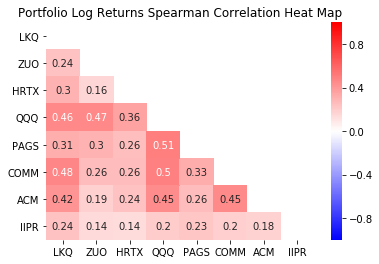

In [98]:
matrix = spearman_corr_heatmap(returns)

In [19]:
# Working version
def reduce_portfolio_spearman_corr(returns_dict, preserve_portfolio=True, plot=True):
    
    if preserve_portfolio:
        rets = {}
        rets.update(returns_dict)
    
    original = spearman_corr_heatmap(rets, plot=False)
    table = []
    
    for i in range(len(original)):
        for j in range(len(original)):
            if i is not j:
                stock_i = original.index[i]
                stock_j = original.index[j]
                coeff = original.values[i][j]
                table.append([stock_i, stock_j, coeff])
                
    corr_matrix_list = pd.DataFrame(table, columns=['stock_i', 'stock_j', 'coeff'])
    
    corr_matrix_list['ranked coeff'] = corr_matrix_list['coeff'].rank(method='min')
    
    corr_matrix_list['weighted coeff'] = corr_matrix_list['coeff']*corr_matrix_list['ranked coeff']
    
    summed = corr_matrix_list.groupby(corr_matrix_list.index//(len(original)-1)).sum()
    
    summed['normalized weights'] = summed['weighted coeff']/(len(original)-1)
    
    summed = summed.set_index(original.index)
    
    summed = summed.sort_values('normalized weights', ascending=False)
    
    r = rets
    r.pop(summed.index[0])
    
    return spearman_corr_heatmap(p)

In [20]:
# Version to test
def reduce_portfolio_spearman_corr(returns_dict, plot=True):
    rets = {}
    rets.update(returns_dict)
    original = spearman_corr_heatmap(rets, plot=False)
    table = []
    for i in range(len(original)):
        for j in range(len(original)):
            if i is not j:
                stock_i = original.index[i]
                stock_j = original.index[j]
                coeff = original.values[i][j]
                table.append([stock_i, stock_j, coeff])
    corr_matrix_list = pd.DataFrame(table, columns=['stock_i', 'stock_j', 'coeff'])
    print(corr_matrix_list)
    corr_matrix_list['ranked coeff'] = corr_matrix_list['coeff'].rank(method='dense')   
    print(corr_matrix_list)
    corr_matrix_list['weighted coeff'] = corr_matrix_list['coeff']*corr_matrix_list['ranked coeff']
    print(corr_matrix_list)
    summed = corr_matrix_list.groupby(corr_matrix_list.index//(len(original)-1)).sum()
    print(summed)
    summed['normalized weights'] = summed['weighted coeff']/(len(original)-1)
    print(summed)
    summed = summed.set_index(original.index)
    print(summed)
    summed = summed.sort_values('normalized weights', ascending=False)
    print(summed)
    r = rets
    r.pop(summed.index[0])
    return spearman_corr_heatmap(r)

   stock_i stock_j     coeff
0      LKQ     ZUO  0.241785
1      LKQ    HRTX  0.303788
2      LKQ     QQQ  0.464655
3      LKQ    PAGS  0.314098
4      LKQ    COMM  0.475787
5      LKQ     ACM  0.421394
6      LKQ    IIPR  0.240984
7      ZUO     LKQ  0.241785
8      ZUO    HRTX  0.161836
9      ZUO     QQQ  0.466116
10     ZUO    PAGS  0.302059
11     ZUO    COMM  0.264849
12     ZUO     ACM  0.186831
13     ZUO    IIPR  0.143598
14    HRTX     LKQ  0.303788
15    HRTX     ZUO  0.161836
16    HRTX     QQQ  0.363548
17    HRTX    PAGS  0.255494
18    HRTX    COMM  0.259442
19    HRTX     ACM  0.241910
20    HRTX    IIPR  0.139595
21     QQQ     LKQ  0.464655
22     QQQ     ZUO  0.466116
23     QQQ    HRTX  0.363548
24     QQQ    PAGS  0.505793
25     QQQ    COMM  0.498918
26     QQQ     ACM  0.453008
27     QQQ    IIPR  0.197563
28    PAGS     LKQ  0.314098
29    PAGS     ZUO  0.302059
30    PAGS    HRTX  0.255494
31    PAGS     QQQ  0.505793
32    PAGS    COMM  0.326300
33    PAGS    

,LKQ,ZUO,HRTX,PAGS,COMM,ACM,IIPR
LKQ,1.000000,0.241785,0.303788,0.314098,0.475787,0.421394,0.240984
ZUO,0.241785,1.000000,0.161836,0.302059,0.264849,0.186831,0.143598
HRTX,0.303788,0.161836,1.000000,0.255494,0.259442,0.241910,0.139595
PAGS,0.314098,0.302059,0.255494,1.000000,0.326300,0.258049,0.226354
COMM,0.475787,0.264849,0.259442,0.326300,1.000000,0.453434,0.195139
ACM,0.421394,0.186831,0.241910,0.258049,0.453434,1.000000,0.175017
IIPR,0.240984,0.143598,0.139595,0.226354,0.195139,0.175017,1.000000


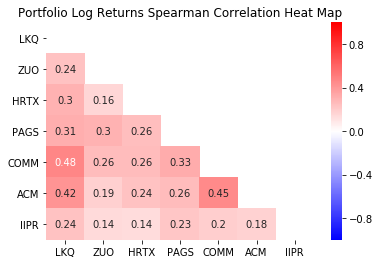

In [21]:
reduce_portfolio_spearman_corr(returns)

,LKQ,ZUO,HRTX,QQQ,PAGS,COMM,ACM,IIPR
LKQ,1.000000,0.241785,0.303788,0.464655,0.314098,0.475787,0.421394,0.240984
ZUO,0.241785,1.000000,0.161836,0.466116,0.302059,0.264849,0.186831,0.143598
HRTX,0.303788,0.161836,1.000000,0.363548,0.255494,0.259442,0.241910,0.139595
QQQ,0.464655,0.466116,0.363548,1.000000,0.505793,0.498918,0.453008,0.197563
PAGS,0.314098,0.302059,0.255494,0.505793,1.000000,0.326300,0.258049,0.226354
COMM,0.475787,0.264849,0.259442,0.498918,0.326300,1.000000,0.453434,0.195139
ACM,0.421394,0.186831,0.241910,0.453008,0.258049,0.453434,1.000000,0.175017
IIPR,0.240984,0.143598,0.139595,0.197563,0.226354,0.195139,0.175017,1.000000


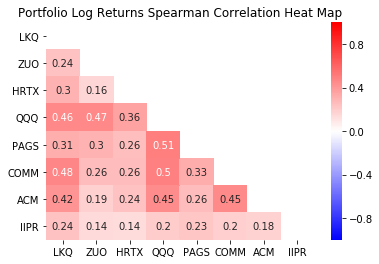

In [99]:
spearman_corr_heatmap(returns)

In [63]:
no_IIPR = {}
no_IIPR.update(returns)

,LKQ,ZUO,HRTX,QQQ,PAGS,COMM,ACM
LKQ,1.000000,0.241785,0.303788,0.464655,0.314098,0.475787,0.421394
ZUO,0.241785,1.000000,0.161836,0.466116,0.302059,0.264849,0.186831
HRTX,0.303788,0.161836,1.000000,0.363548,0.255494,0.259442,0.241910
QQQ,0.464655,0.466116,0.363548,1.000000,0.505793,0.498918,0.453008
PAGS,0.314098,0.302059,0.255494,0.505793,1.000000,0.326300,0.258049
COMM,0.475787,0.264849,0.259442,0.498918,0.326300,1.000000,0.453434
ACM,0.421394,0.186831,0.241910,0.453008,0.258049,0.453434,1.000000


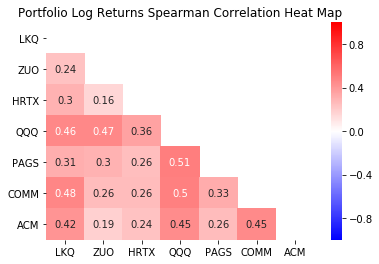

In [89]:
spearman_corr_heatmap(no_IIPR)

In [62]:
def mean_corr_coeff(returns_dict):
    coeffs = []
    stock_avg_corr = pd.DataFrame()
    avg_corr = []
    avgs = pd.DataFrame(columns= matrix.keys())
    for i in range(0, len(matrix)):
        for j in range(1, len(matrix)):
            if i is not j:
                coeffs.append(matrix.values[i][j])
        ind = list(matrix.keys()).remove(list(matrix.keys())[i])
        stock_avg_corr = pd.DataFrame(coeffs, index=ind).dropna().mean()[0]
        avg_corr.append(stock_avg_corr)
    corrs = avgs.append(pd.Series(avg_corr, index=avgs.columns).rename('Mean corr coeff'))
    return corrs

In [102]:
r = mean_corr_coeff(returns)

In [104]:
r

,LKQ,ZUO,HRTX,QQQ,PAGS,COMM,ACM,IIPR
Mean corr coeff,0.351784,0.306752,0.284716,0.315782,0.315116,0.318018,0.314766,0.298208


In [110]:
r.mean(axis=1)

Mean corr coeff    0.313143
dtype: float64

In [115]:
r.count(axis=1)[0]

8

In [109]:
r.std(axis=1)/r.count

Mean corr coeff    0.019281
dtype: float64

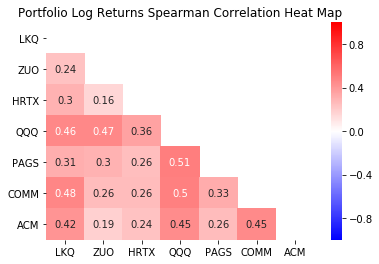

In [91]:
matrix = spearman_corr_heatmap(no_IIPR)

In [92]:
r = mean_corr_coeff(no_IIPR)

In [93]:
r.mean(axis=1)

Mean corr coeff    0.338002
dtype: float64

In [29]:
def plot_scatter_matrix(returns_dict):
    
    rets = pd.DataFrame()
    for s, d in returns_dict.items():
        rets[s] = returns_dict[s]['log returns']
    ax = sns.pairplot(rets)
    plt.show()

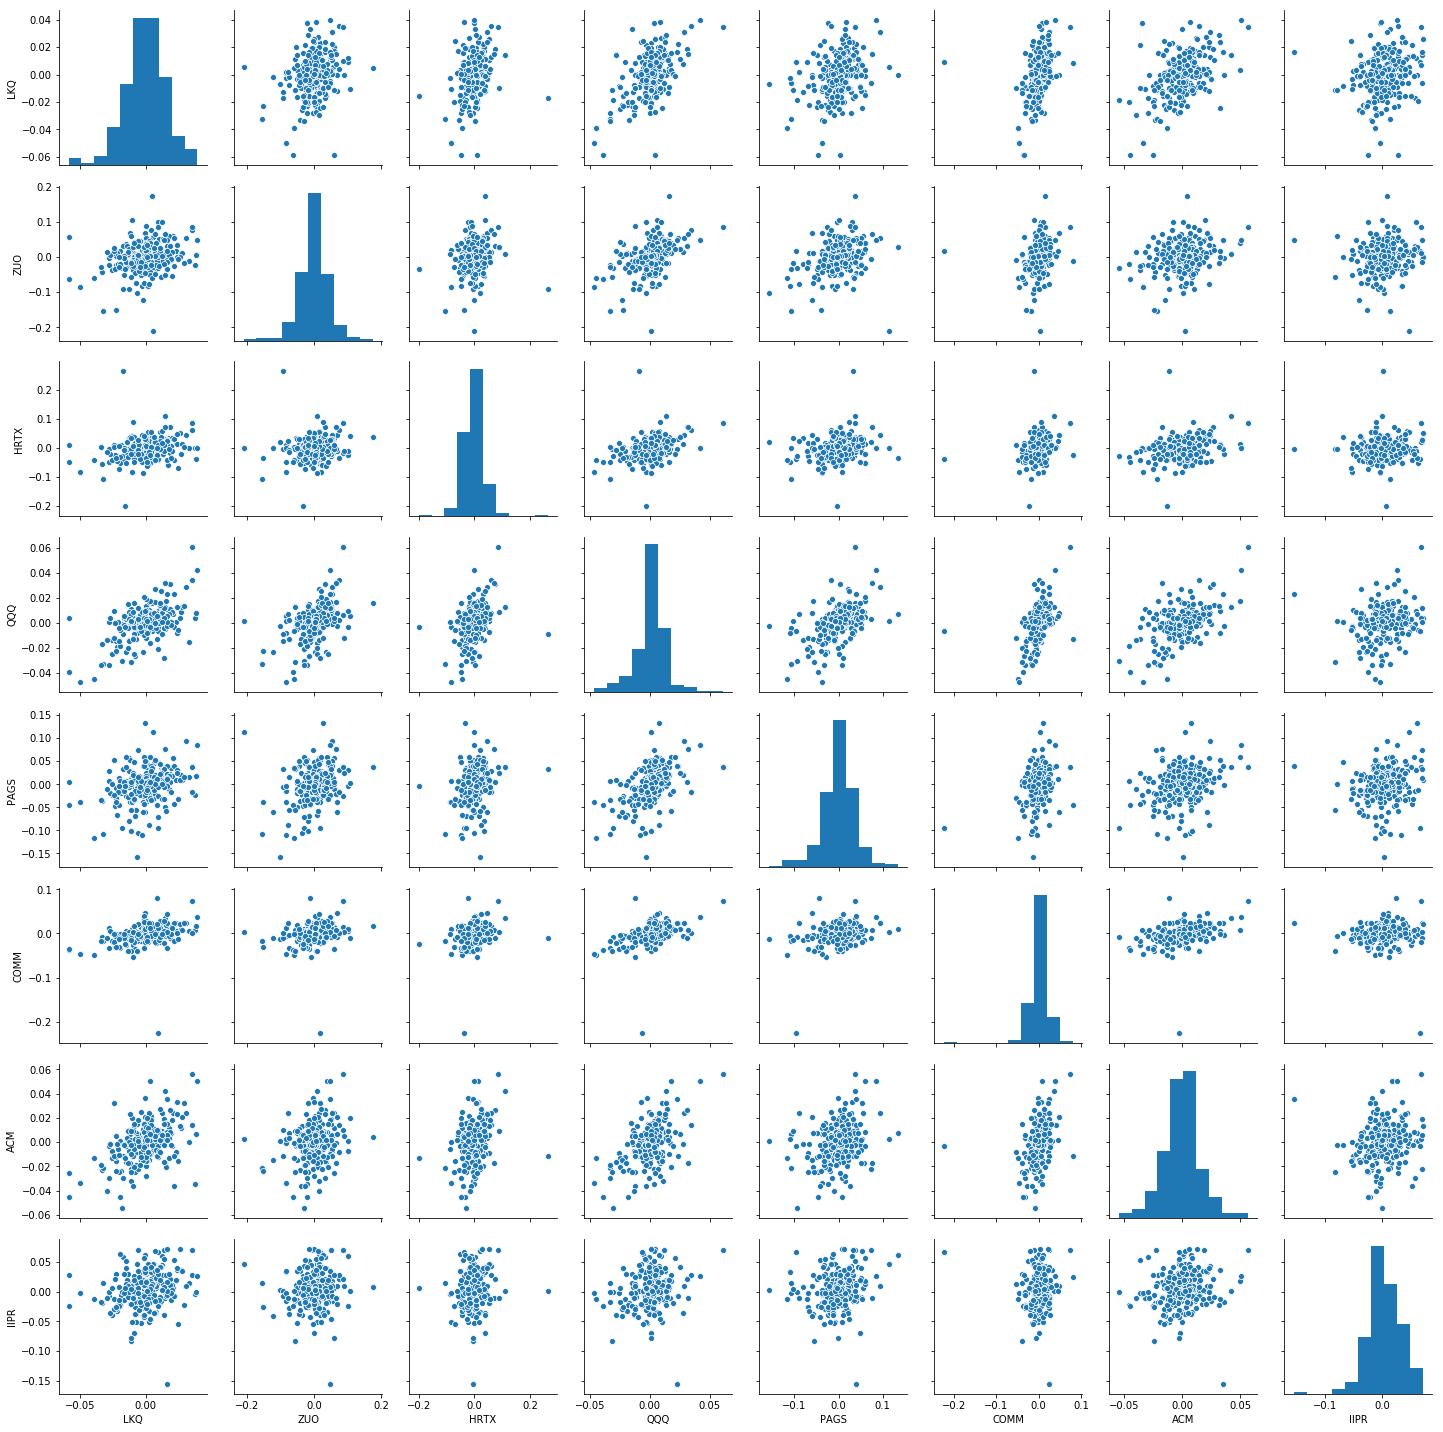

In [52]:
plot_scatter_matrix(returns)

## Adjusted for Skewness and Kurtosis Sharpe Ratio (ASKSR)

This is a gross oversimplification of the problem that arises with using the standard mean-variance-based Sharpe Ratio. When using the Sharpe Ratio to determine the "risk-reward" value of owning an asset or portfolio of assets, it is assumed that the return data is normally distributed. However, this is almost never the case, so the value of the Sharpe Ratio can be misleading. To account for this, Zakamouline and Koekebakker (2008) authored an article deriving a parametric form of a special-case form of the generalized Sharpe Ratio that accounts for higher-order moments of distribution than just mean and variance. That is, the returns are not assumed to be normally disributed, so the ASKSR accounts for skewness (3rd moment) and kurtossis (4th moment) of the returns distribution of an asset. To read more into the "nitty-gritty," click on the link below.

https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1028715

The authors chose to use the normal inverse Gaussian distribution (NIGD) because:
1. NIGD has an explicit expression for the probability density function
2. Distributions of risky asset returns can be often fitted extremely well by the NIGD
3. For the NIGD, there are explicit formulas for finding the parameters of the distribution via the values of the first four moments of the distribution.

$\eta$ and $\delta$ are ordinary paramters of location and scale whereas $\alpha$ and $\beta$ determine the shape of the density. In particular, $\beta$ determines the degree of skewwness.

For symmetrical densities, $\beta = 0$. The conditions for a viable NIG density are $\delta > 0$, $\alpha > 0$, and $\frac{\vert \beta \vert}{\alpha} < 1$. Note that to get meaningful parameters of the NIGD, the following conditions must be satisfied:

\begin{align}
K > 3 + \frac{5}{3}S^2
\end{align}

* Mean: $\mu = \eta + \delta\frac{\beta}{\varphi}$

* Variance: $\sigma^2 = \delta\frac{\alpha^2}{\varphi^3}$

* Skew: $S = 3\frac{\beta}{\alpha \sqrt{\delta\varphi}}$

* Kurtosis: $K = 3 + \frac{3}{\delta\varphi}\left( 1 + 4\left(\frac{\beta}{\alpha} \right)^2 \right)$

\begin{align}
ASKSR &= \sqrt{2\left(\lambda a^*(\eta - r) -\delta\left (\varphi - \sqrt{\alpha^2 - (\beta - \lambda a^*)^2}\right)\right)} \\\\
\end{align}

\begin{align}
a^* &= \frac{1}{\lambda}\left(\beta + \frac{\alpha(\eta - r)}{\sqrt{\delta^2 + (\eta - r)^2}} \right) \\\\
\varphi &= \sqrt{\alpha^2 - \beta^2} \\\\
\alpha &= \frac{3\sqrt{a}}{\sigma^2 b} \\\\
\beta &= \frac{3S}{\sigma b} \\\\
\eta &= \mu - \frac{3S\sigma}{a} \\\\
\delta &= 3\sigma\frac{\sqrt{b}}{a} \\\\
a &= 3K - 4S^2 - 9 \\\\
b &= 3K - 5S^2 - 9 \\
\end{align}

In [31]:
# Compute the generalized skew-kurtosis Sharpe Ratio as explained in 
# "Portfolio performance evaluation with generalized Sharpe ratios: 
# Beyond the mean and variance" (Zakamouline and Koekebakker, 2008).

# returns_data: DataFrame with Timestamp indices and daily pct change.
# window: size of rolling window.
def asksr(returns_dict, ticker, window=30):
    
    # Create a dataframe in which to store ASKSR and SR values and
    # model assumptions required to verify the validity of ASKSR values.
    sharpes = pd.DataFrame(
        columns=['ASKSR', 
                 'SR', 
                 'Delta > 0', 
                 'Alpha > 0', 
                 'Beta/alpha < 1',
                 'Kurtosis/Skewness'])
    
    # Use the U.S. Treasury long-term bill rate of return as the "risk free rate"
    risk_free = q.get('USTREASURY/REALLONGTERM', start_date=start, end_date=end).dropna().pct_change()
    risk_free_rolling = risk_free.rolling(window=30, min_periods=4).mean().dropna().values.tolist()
    
    # Generate a Rolling object over which to compute the rolling statistical moments.
    rolling = returns_dict[ticker]['pct change'].rolling(window=30, min_periods=4)
    mean = rolling.mean().dropna()
    var = rolling.var().dropna()
    std = rolling.std().dropna()
    skew = rolling.apply(lambda x : stats.skew(x), raw=True).dropna()
    kurt = rolling.apply(lambda x : stats.kurtosis(x), raw=True).dropna()

    # For each set of rolling values per date, compute the parameters describing ASKSR.
    for m, v, st, sk, ku, r, date in zip(mean, var, std, skew, kurt, risk_free_rolling, returns_dict[ticker].index):
        
        a = 3*ku - 4*(sk**2)-9
        b = 3*ku - 5*(sk**2)-9
        alpha = (3*c.sqrt(a))/(v*b)
        beta = (3*sk)/(c.sqrt(v)*b)
        eta = m - (3*sk*c.sqrt(v))/(a)
        sigma = 3*c.sqrt(v)*(c.sqrt(b)/a)
        phi = c.sqrt(alpha**2 - beta**2)
        delta = (m - eta)*(phi/beta)
        a_star = beta + (alpha*(eta - r[0]))/(c.sqrt(delta**2 + (eta - r[0])**2))

        # cmath library is used to handle complex values (unsure if this should be expected).
        ASKSR = c.sqrt(2*(a_star*(eta - r[0]) - delta*(
            phi - c.sqrt(alpha**2 - (beta - a_star)**2))))*c.sqrt(window)
        ASKSR_mag = ASKSR.real**2 + ASKSR.imag**2
        SR = ((m - r[0])/(np.sqrt(v) - r[0]))*np.sqrt(window)
        
        # Generate a Pandas Series to append to the sharpes dataframe.
        row = pd.Series([float('%.3f'%(ASKSR_mag)), 
                        float('%.3f'%(SR)), 
                        str(delta.real > 0),
                        str(alpha.real > 0), 
                        str((np.abs(beta)/alpha) < 1), 
                        str(ku > (5/3)*(sk**2) + 3)], 
                       index=sharpes.columns).rename(date)
        sharpes = sharpes.append(row)
    
    return sharpes

In [32]:
# Create a dataframe in which to store pct returns of all stocks in port.
p = pd.DataFrame()

# For each stock, extract the percent change and add it to p.
for tick, data in returns.items():
    p[tick] = data['pct change']

# Calculate the net return of the portfolio after each trading day.
p['net'] = p.sum(axis=1)

In [33]:
p.head()

,LKQ,ZUO,HRTX,QQQ,PAGS,COMM,ACM,IIPR,net
date,,,,,,,,,
2018-05-07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-05-08,-0.003590,0.013506,-0.043818,-0.001023,-0.016822,0.018307,0.025195,-0.015195,-0.023439
2018-05-09,-0.010809,0.014352,-0.004910,0.010899,0.014575,0.003392,-0.031356,-0.010189,-0.014046
2018-05-10,0.002649,0.012633,-0.021382,0.010365,-0.008745,-0.002705,-0.011374,-0.049118,-0.067676
2018-05-11,0.000000,0.005988,0.033613,-0.000943,0.018904,0.013559,-0.019174,0.029384,0.081332


In [34]:
s = asksr(returns, 'IIPR')

In [44]:
s.describe()

,ASKSR,SR
count,244.000000,244.000000
mean,23.589836,-0.005836
std,48.134402,3.529239
min,0.005000,-40.953000
25%,1.776250,-0.693250
50%,8.979000,0.833500
75%,18.195750,1.506000
max,274.414000,3.083000


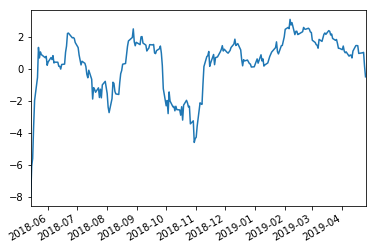

In [51]:
s['SR'][5:].plot();

Notice how the ASKSR readings tend to be much greater than the standard SR and has a tendency to become extremely large.

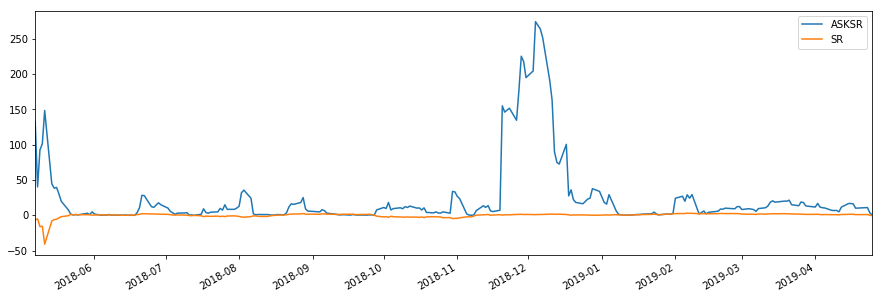

In [36]:
s.plot(figsize=(15,5));

# Technical Indicators (NOT UPDATED AS OF 4/29)

In [38]:
stock = 'IIPR'

# Enter start date
start = '2018-05-05'

# Default set to today
end = dt.datetime.today().strftime('%Y-%m-%d')
ti = TechIndicators(key= api_keys[0], output_format='pandas', indexing_type='date')

macd, macd_meta = ti.get_macd(stock)
macd = pd.DataFrame(macd)
macd.index = pd.to_datetime(macd.index)

rsi, rsi_meta = ti.get_rsi(stock)
rsi = pd.DataFrame(rsi)
rsi.index = pd.to_datetime(rsi.index)

boll, boll_meta = ti.get_bbands(stock, time_period=60)
boll = pd.DataFrame(boll)
boll.index = pd.to_datetime(boll.index)

ad, ad_meta = ti.get_ad(stock)
ad = pd.DataFrame(ad)
ad.index = pd.to_datetime(ad.index)

obv, obv_meta = ti.get_obv(stock)
obv = pd.DataFrame(obv)
obv.index = pd.to_datetime(obv.index)

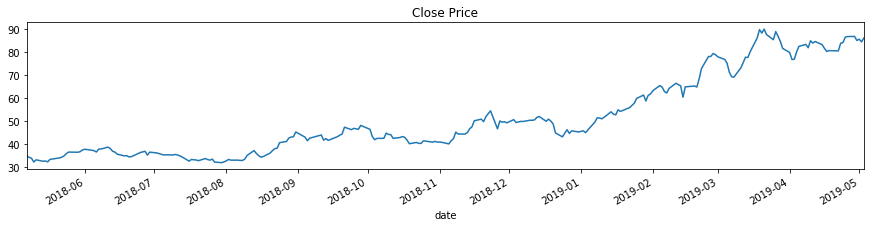

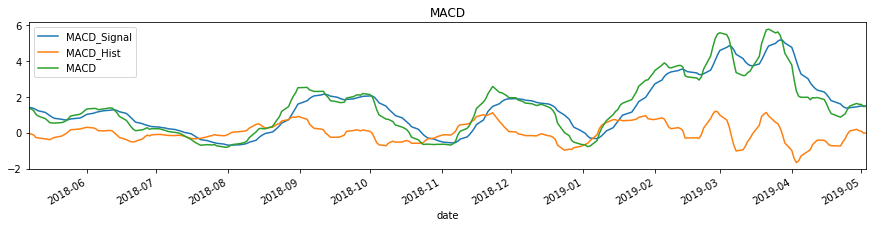

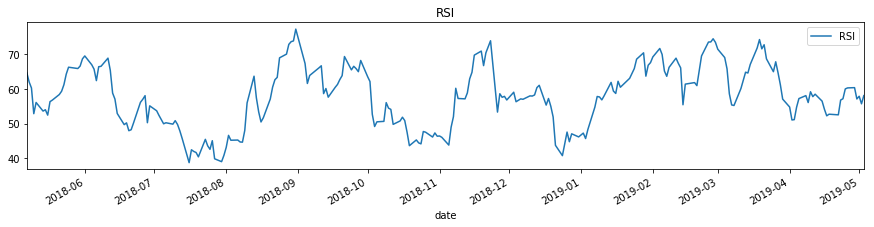

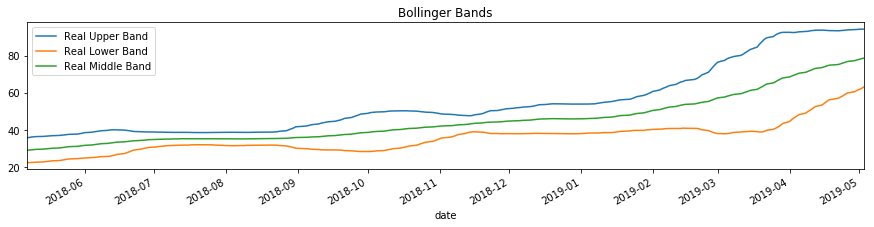

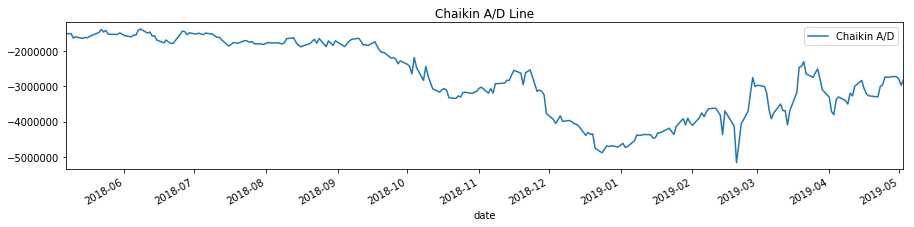

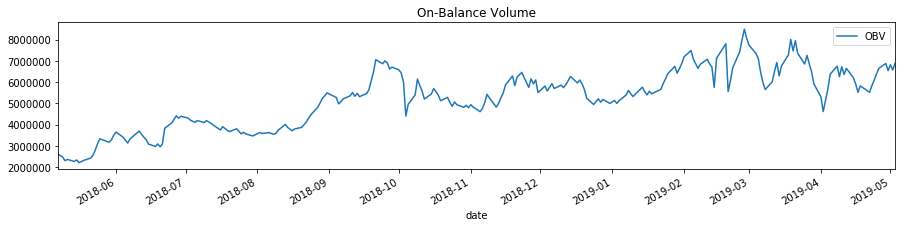

In [43]:
size = (15,3)

start = '2018-05-05'
port[stock]['close'][start:end].plot(title='Close Price', figsize=size)
macd[start:end].plot(title= 'MACD', figsize=size);
rsi[start:end].plot(title='RSI', figsize=size);
boll[start:end].plot(title='Bollinger Bands', figsize=size);
ad[start:end].plot(title='Chaikin A/D Line', figsize=size);
obv[start:end].plot(title='On-Balance Volume', figsize=size);

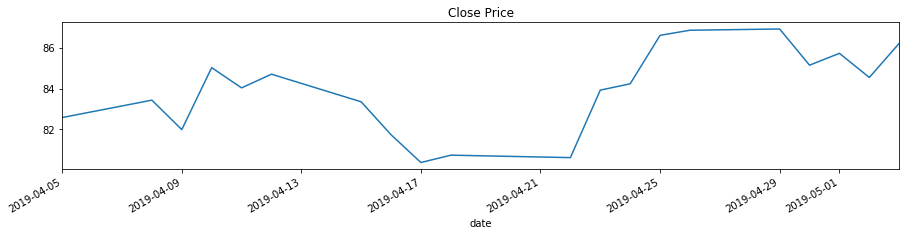

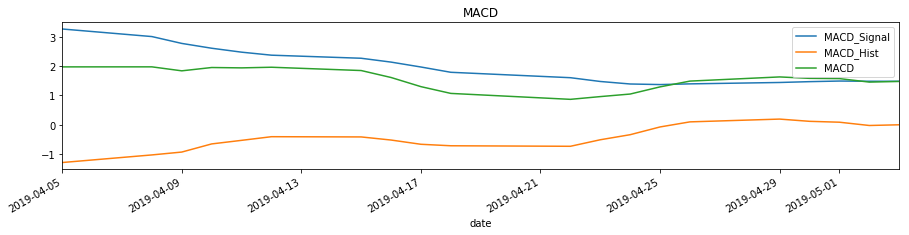

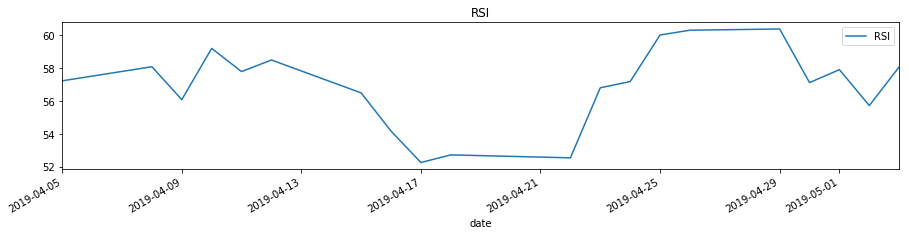

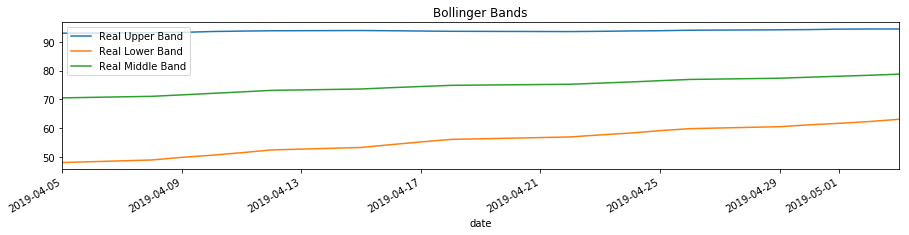

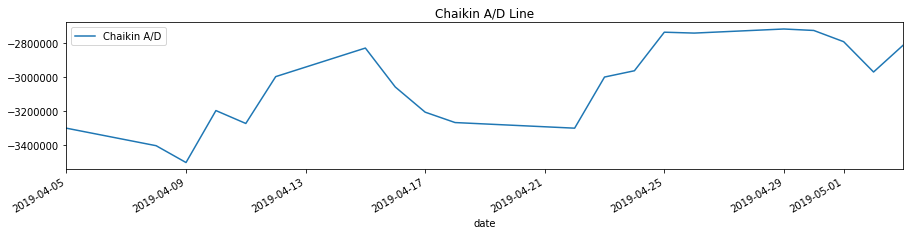

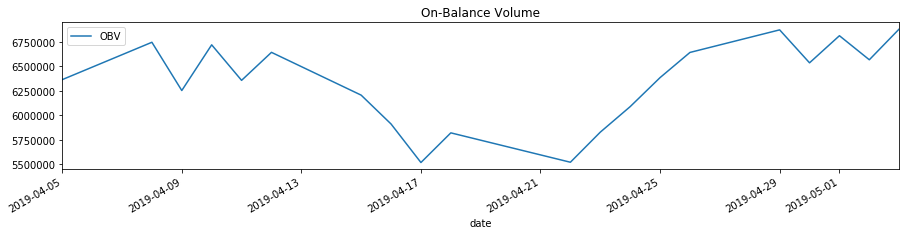

In [42]:
start = '2019-04-05'

size = (15,3)
port[stock]['close'][start:end].plot(title='Close Price', figsize=size)
macd[start:end].plot(title= 'MACD', figsize=size);
rsi[start:end].plot(title='RSI', figsize=size);
boll[start:end].plot(title='Bollinger Bands', figsize=size);
ad[start:end].plot(title='Chaikin A/D Line', figsize=size);
obv[start:end].plot(title='On-Balance Volume', figsize=size);

# Under Construction

In [ ]:
def compare_corr_matrix(org_matrix=plot_corr_matrix(), add=None, remove=None):
    org = port
    for a in add:
        collect(add_to_port=False)
    return org

In [ ]:
port.

In [ ]:
compare_corr_matrix()

## Efficiency Ratio

In [ ]:
def eff_rat(symbol, period=7):
    close_data = port[symbol]['close']
    close
    
    return pd.DataFrame()

In [ ]:
close_data = port['EPD']['close']

abs_change = close_data.diff().resample('7D').sum()
#summed_data = close_data.resample('7D')